# TCGA-BRCA Survival Analysis

## Objective
To analyze the TCGA-BRCA dataset, perform feature selection, clustering, and survival analysis to identify the impact of gene expression on survival patterns.


## Instructions
1. Data Download:
    - Download the TCGA-BRCA dataset from the cBioPortal website: https://www.cbioportal.org/
    - Ensure you download the gene expression data and the clinical data files.


In [15]:
## Data Download
#Download the following files from [cBioPortal Datahub](https://github.com/cBioPortal/datahub/tree/master/public/brca_tcga):
#- `data_clinical_patient.txt`
#- `data_mrna_seq_v2_rsem.txt`


Imports 

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import random

# Set matplotlib to display plots inline in Jupyter notebooks
%matplotlib inline

# Import necessary libraries for survival analysis, clustering, and visualization
# - pandas and numpy for data manipulation and numerical operations
# - lifelines for survival analysis
# - sklearn for clustering and silhouette score
# - matplotlib for plotting
# - random for random number generation


### Load Gene Expression Data
Load the gene expression data from the downloaded file.


In [3]:
# Generic paths for data files
gene_expression_path = "data_mrna_seq_v2_rsem.txt"
clinical_patient_file_path = "data_clinical_patient.txt"

# Load the gene expression data
gene_expression_df = pd.read_csv(gene_expression_path, sep='\t')


### Preprocess Gene Expression Data
1. Remove rows with missing Hugo_Symbol
2. Handle missing values by replacing them with 0
3. Convert data types to numeric
4. Sum the values across the columns (samples) for each gene (row)
5. Filter out genes with low expression (sum of expression values < 10)
6. Remove genes whose expression is zero in more than 50% of the samples
7. Log transformation of the gene expression values
8. Z-score normalization


In [4]:
# Remove rows with missing Hugo_Symbol
gene_expression_df = gene_expression_df.dropna(subset=['Hugo_Symbol'])

# Handle missing values by replacing them with 0 (if any)
gene_expression_df = gene_expression_df.fillna(0)

# Convert data types to numeric (in case there are any non-numeric values)
gene_expression_df.iloc[:, 2:] = gene_expression_df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

# Sum the values across the columns (samples) for each gene (row)
gene_sums = gene_expression_df.iloc[:, 2:].sum(axis=1)

# Filter out genes with low expression (e.g., sum of expression values < 10)
filtered_genes = gene_expression_df[gene_sums >= 10]
print("Number of genes after low expression filter:", filtered_genes.shape[0])

# Remove genes whose expression is zero in more than 50% of the samples
filtered_genes = filtered_genes.loc[(filtered_genes.iloc[:, 2:] != 0).sum(axis=1) > (0.5 * filtered_genes.shape[1])]
print("Number of genes after removing zero-expression genes in more than 50% of samples:", filtered_genes.shape[0])

# Log transformation of the gene expression values
filtered_genes.iloc[:, 2:] = np.log1p(filtered_genes.iloc[:, 2:])

# Z-score normalization
filtered_genes.iloc[:, 2:] = (filtered_genes.iloc[:, 2:] - filtered_genes.iloc[:, 2:].mean()) / filtered_genes.iloc[:, 2:].std()


Number of genes after low expression filter: 19893
Number of genes after removing zero-expression genes in more than 50% of samples: 17646


### Prepare Gene Expression Data for Merging
1. Set Hugo_Symbol as index
2. Standardize patient IDs
3. Save the final filtered and normalized data for further analysis


In [5]:
# Prepare gene expression data for merging, use Hugo_Symbol as index
filtered_genes = filtered_genes.set_index('Hugo_Symbol').T
filtered_genes.index = filtered_genes.index.str.replace(r'-01$', '', regex=True)
print("Patient IDs in gene expression data standardized.")

# Save the final filtered and normalized data for further analysis
filtered_genes.to_csv('filtered_gene_expression_data_zscores.csv', sep='\t')


Patient IDs in gene expression data standardized.


### Load and Prepare Clinical Data
1. Load the clinical data from the downloaded file
2. Extract relevant columns for survival analysis
3. Convert survival status to numeric
4. Ensure patient IDs are strings


In [6]:
# Load the clinical data
clinical_data = pd.read_csv(clinical_patient_file_path, sep="\t", comment='#', header=0)

# Extract relevant columns for survival analysis
survival_columns = ['PATIENT_ID', 'OS_STATUS', 'OS_MONTHS']
survival_data = clinical_data[survival_columns]

# Convert survival status to numeric
survival_data['OS_STATUS'] = survival_data['OS_STATUS'].apply(lambda x: 1 if 'DECEASED' in x else 0)

# Ensure patient IDs are strings
survival_data['PATIENT_ID'] = survival_data['PATIENT_ID'].astype(str)


/tmp/ipykernel_25/3816812630.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['OS_STATUS'] = survival_data['OS_STATUS'].apply(lambda x: 1 if 'DECEASED' in x else 0)
/tmp/ipykernel_25/3816812630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_data['PATIENT_ID'] = survival_data['PATIENT_ID'].astype(str)


### Merge Gene Expression Data with Clinical Data
Merge the clinical data with the prepared gene expression data.


In [7]:
# Merge with clinical data
data = pd.merge(survival_data, filtered_genes, left_on='PATIENT_ID', right_index=True)

# Save the merged data for further analysis
data.to_csv('merged_clinical_gene_expression_data.csv', sep='\t', index=False)

print("Merged data saved.")
print(data.head())


Merged data saved.
     PATIENT_ID  OS_STATUS   OS_MONTHS  UBE2Q2P2   HMGB1P1  RNU12-2P  \
0  TCGA-3C-AAAU          0  133.050597 -1.069753 -0.506588 -2.177674   
1  TCGA-3C-AALI          0  131.669790 -1.025308 -0.435159 -1.977608   
2  TCGA-3C-AALJ          0   48.459743 -1.207106 -0.053999 -2.192844   
3  TCGA-3C-AALK          0   47.604958 -1.229677 -0.136145 -2.174022   
4  TCGA-4H-AAAK          0   11.440971 -1.077535 -0.338042 -2.108233   

     EFCAB8   SRP14P1   HSPB1P1    GTPBP6  ...    ZWILCH     ZWINT      ZXDA  \
0 -2.053105 -1.489469  0.207807  0.400552  ...  0.359650  0.698523 -0.128490   
1 -1.523196 -1.876255  0.375444  0.558405  ...  0.790197  0.709288 -0.501435   
2 -1.635935 -1.635935  0.776557  0.558283  ...  0.234110  1.129402 -0.669505   
3 -1.832859 -1.571942  0.318887  0.609126  ...  0.305965  0.537727 -0.554305   
4 -1.664051 -1.664051 -0.296650  0.577303  ...  0.338314  0.557845 -0.569302   

       ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX     ZZEF1      

## Feature Selection
Perform feature selection to identify the top 100 genes most associated with survival.


In [8]:
# Load the merged clinical and gene expression data
merged_data_path = "merged_clinical_gene_expression_data.csv"
merged_data = pd.read_csv(merged_data_path, sep='\t')

# Ensure the data types are correct
merged_data['OS_STATUS'] = merged_data['OS_STATUS'].astype(int)
merged_data['OS_MONTHS'] = merged_data['OS_MONTHS'].astype(float)

# Extract gene expression data and clinical data
clinical_data = merged_data[['PATIENT_ID', 'OS_STATUS', 'OS_MONTHS']]
gene_expression_data = merged_data.drop(columns=['PATIENT_ID', 'OS_STATUS', 'OS_MONTHS'])

print("Data loaded and prepared.")

# Initialize the CoxPH model
cph = CoxPHFitter()

# Store the p-values of the genes
p_values = []

# Loop through each gene to fit the CoxPH model and extract p-values
for gene in gene_expression_data.columns:
    gene_df = pd.DataFrame({
        'OS_MONTHS': clinical_data['OS_MONTHS'],
        'OS_STATUS': clinical_data['OS_STATUS'],
        gene: gene_expression_data[gene]
    })
    cph.fit(gene_df, duration_col='OS_MONTHS', event_col='OS_STATUS')
    p_values.append((gene, cph.summary.loc[gene, 'p']))

# Convert the p-values to a DataFrame and sort by p-value
p_values_df = pd.DataFrame(p_values, columns=['Gene', 'P-Value'])
p_values_df = p_values_df.sort_values(by='P-Value')

# Select the top 100 genes
top_100_genes = p_values_df.head(100)['Gene'].tolist()

print("Top 100 genes selected based on CoxPH model.")


Data loaded and prepared.
Top 100 genes selected based on CoxPH model.


## Clustering
Using the top 100 selected genes, perform clustering using the k-means algorithm.


In [9]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Function to perform log-rank test for a gene
def perform_logrank_test(gene):
    high_expression = merged_data[gene_expression_data[gene] >= gene_expression_data[gene].median()]
    low_expression = merged_data[gene_expression_data[gene] < gene_expression_data[gene].median()]

    results = logrank_test(
        high_expression['OS_MONTHS'], low_expression['OS_MONTHS'],
        event_observed_A=high_expression['OS_STATUS'], event_observed_B=low_expression['OS_STATUS']
    )
    return results.p_value

# Validate top genes using log-rank test
logrank_p_values = {gene: perform_logrank_test(gene) for gene in top_100_genes}

# Convert log-rank p-values to a DataFrame and sort by p-value
logrank_p_values_df = pd.DataFrame(list(logrank_p_values.items()), columns=['Gene', 'Log-Rank P-Value'])
logrank_p_values_df = logrank_p_values_df.sort_values(by='Log-Rank P-Value')

print("Log-rank test validation completed for top 100 genes.")

# Save the top 100 genes based on CoxPH model
top_100_genes_df = p_values_df.head(100)
top_100_genes_df.to_csv('top_100_genes_coxph.csv', sep='\t', index=False)

# Save the log-rank validated top 100 genes (optional)
logrank_validated_genes_df = logrank_p_values_df.head(100)
logrank_validated_genes_df.to_csv('logrank_validated_top_100_genes.csv', sep='\t', index=False)

print("Top 100 genes and log-rank validated genes saved.")


Log-rank test validation completed for top 100 genes.
Top 100 genes and log-rank validated genes saved.


### Load Top 100 Genes Data
Load the data for the top 100 genes.


In [10]:
# Load the top 100 genes data
top_100_genes_path = "top_100_genes_coxph.csv"
top_100_genes_df = pd.read_csv(top_100_genes_path, sep='\t')

# Extract gene names
top_100_gene_names = top_100_genes_df['Gene'].tolist()

# Load the merged clinical and gene expression data
merged_data_path = "merged_clinical_gene_expression_data.csv"
merged_data = pd.read_csv(merged_data_path, sep='\t')

# Extract the gene expression data for the top 100 genes
gene_expression_data = merged_data[top_100_gene_names]

print("Top 100 genes data loaded.")


Top 100 genes data loaded.


### Perform K-means Clustering
Use the k-means algorithm to cluster patients based on the expression of the top 100 genes.


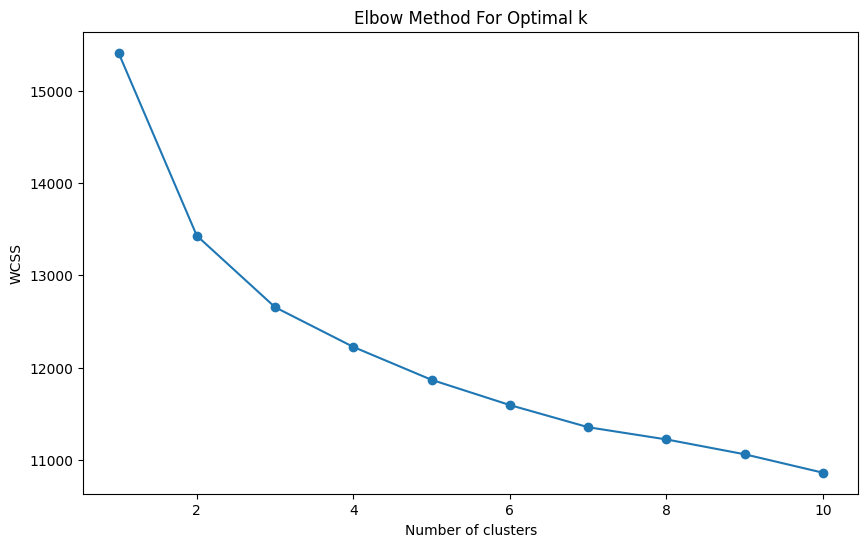

Elbow method plot created.


In [11]:
# Perform K-means clustering
def perform_kmeans(gene_expression_data, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(gene_expression_data)
    return kmeans

# Function to plot the elbow method
def plot_elbow_method(gene_expression_data):
    wcss = []
    for i in range(1, 11):
        kmeans = perform_kmeans(gene_expression_data, i)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

plot_elbow_method(gene_expression_data)
print("Elbow method plot created.")


### Determine Optimal Number of Clusters
Use the silhouette score to determine the optimal number of clusters.


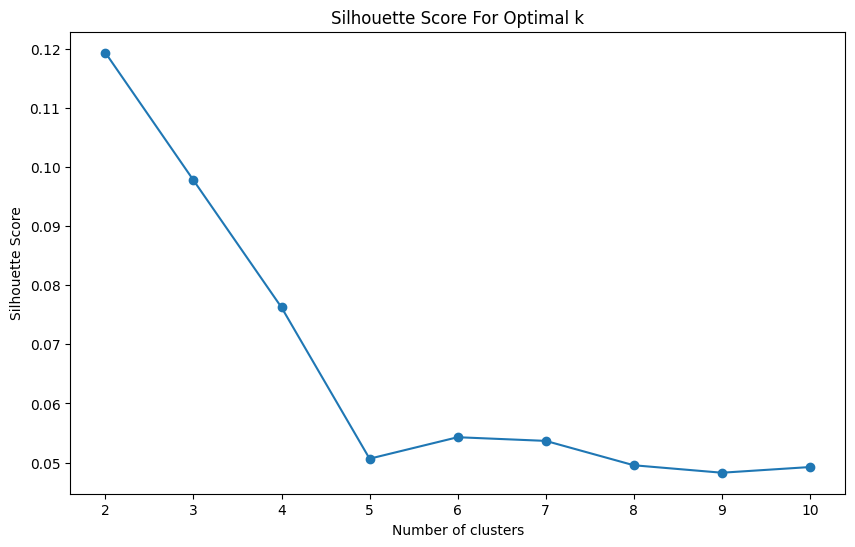

Silhouette score plot created.
Patients assigned to clusters and data saved.


In [12]:
# Function to calculate silhouette scores
def calculate_silhouette_scores(gene_expression_data):
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = perform_kmeans(gene_expression_data, i)
        score = silhouette_score(gene_expression_data, kmeans.labels_)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Score For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

calculate_silhouette_scores(gene_expression_data)
print("Silhouette score plot created.")

# Let's assume the optimal number of clusters is determined to be 3
optimal_k = 3

# Perform K-means clustering with the optimal number of clusters
kmeans = perform_kmeans(gene_expression_data, optimal_k)
clusters = kmeans.labels_

# Add the cluster assignments to the merged data
merged_data['Cluster'] = clusters

# Save the data with cluster assignments
merged_data.to_csv('merged_data_with_clusters.csv', sep='\t', index=False)

print("Patients assigned to clusters and data saved.")


## Survival Analysis in Clusters
Perform survival analysis within each cluster using Cox Proportional Hazards Model and Kaplan-Meier analysis.


In [13]:
# Function to perform CoxPH analysis
def coxph_analysis(data, gene, cluster):
    cph = CoxPHFitter()
    cluster_data = data[data['Cluster'] == cluster]
    cluster_data = cluster_data[['OS_MONTHS', 'OS_STATUS', gene]]
    cph.fit(cluster_data, duration_col='OS_MONTHS', event_col='OS_STATUS')
    return cph.summary

# Dictionary to store the summaries
coxph_summaries = {}

# Perform CoxPH analysis for each cluster and store the summary
random_gene = random.choice(top_100_gene_names)
for cluster in merged_data['Cluster'].unique():
    summary = coxph_analysis(merged_data, random_gene, cluster)
    coxph_summaries[cluster] = summary
    print(f"CoxPH summary for Cluster {cluster}:")
    print(summary)

# Save the CoxPH summaries to a text file
summary_file_path = "coxph_summaries.txt"

with open(summary_file_path, 'w') as file:
    for cluster, summary in coxph_summaries.items():
        file.write(f"CoxPH summary for Cluster {cluster}:\n")
        file.write(summary.to_string())
        file.write("\n\n")

print(f"CoxPH summaries saved to {summary_file_path}")


CoxPH summary for Cluster 0:
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
PXDNL      0.293031   1.340484  0.161361       -0.023231        0.609293   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
PXDNL                 0.977037              1.83913     0.0  1.815995   

                  p  -log2(p)  
covariate                      
PXDNL      0.069371  3.849521  
CoxPH summary for Cluster 2:
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
PXDNL     -0.083201   0.920166  0.239264       -0.552149        0.385747   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
PXDNL                 

### Kaplan-Meier Analysis
Perform Kaplan-Meier analysis for each cluster and save the results.


In [14]:
# Function to perform Kaplan-Meier analysis
def kaplan_meier_analysis(data, gene, cluster, output_dir):
    kmf_high = KaplanMeierFitter()
    kmf_low = KaplanMeierFitter()

    cluster_data = data[data['Cluster'] == cluster]
    median_expression = cluster_data[gene].median()

    high_expression = cluster_data[cluster_data[gene] > median_expression]
    low_expression = cluster_data[cluster_data[gene] <= median_expression]

    ax = plt.subplot(111)

    kmf_high.fit(high_expression['OS_MONTHS'], event_observed=high_expression['OS_STATUS'], label='High Expression')
    kmf_low.fit(low_expression['OS_MONTHS'], event_observed=low_expression['OS_STATUS'], label='Low Expression')

    kmf_high.plot_survival_function(ax=ax)
    kmf_low.plot_survival_function(ax=ax)

    plt.title(f'Kaplan-Meier Survival Curve for Cluster {cluster} ({gene} Expression)')
    plt.xlabel('Months')
    plt.ylabel('Survival Probability')

    plot_file_path = f"{output_dir}/Kaplan_Meier_Cluster_{cluster}_{gene}.png"
    plt.savefig(plot_file_path)
    plt.close()
    
    print(f"Kaplan-Meier plot saved to {plot_file_path}")

    # Perform log-rank test
    results = logrank_test(high_expression['OS_MONTHS'], low_expression['OS_MONTHS'],
                           event_observed_A=high_expression['OS_STATUS'],
                           event_observed_B=low_expression['OS_STATUS'])

    return results, plot_file_path

# Directory to save the plots and summaries
output_dir = "."

# Perform Kaplan-Meier analysis for each cluster and save results
logrank_results = {}
for cluster in merged_data['Cluster'].unique():
    print(f"Kaplan-Meier analysis for Cluster {cluster}:")
    results, plot_file_path = kaplan_meier_analysis(merged_data, random_gene, cluster, output_dir)
    logrank_results[cluster] = results
    print(results.summary)

# Save log-rank test results to a text file
logrank_results_file_path = f"{output_dir}/logrank_results.txt"
with open(logrank_results_file_path, 'w') as file:
    for cluster, result in logrank_results.items():
        file.write(f"Log-rank test results for Cluster {cluster}:\n")
        file.write(result.summary.to_string())
        file.write("\n\n")

print(f"Log-rank test results saved to {logrank_results_file_path}")


Kaplan-Meier analysis for Cluster 0:
Kaplan-Meier plot saved to ./Kaplan_Meier_Cluster_0_PXDNL.png
   test_statistic         p  -log2(p)
0        5.055914  0.024542  5.348601
Kaplan-Meier analysis for Cluster 2:
Kaplan-Meier plot saved to ./Kaplan_Meier_Cluster_2_PXDNL.png
   test_statistic        p  -log2(p)
0        0.311158  0.57697  0.793431
Kaplan-Meier analysis for Cluster 1:
Kaplan-Meier plot saved to ./Kaplan_Meier_Cluster_1_PXDNL.png
   test_statistic         p  -log2(p)
0        1.188131  0.275707  1.858793
Log-rank test results saved to ./logrank_results.txt


## Results and Interpretation
### Summary of Findings and Interpretation

### Kaplan-Meier Survival Analysis

Kaplan-Meier survival curves were plotted for each cluster based on the expression levels of the gene ADAM6. The patients were divided into high and low expression groups for each cluster, and the survival probability was analyzed over time.

Here are the key points from the Kaplan-Meier analysis:

**Cluster 0:**
- High and low expression groups show slight differences in survival probability over time.
- Log-rank test results:
  - Test Statistic: 0.482674
  - p-value: 0.487214
  - -log2(p): 1.037374

**Cluster 1:**
- High and low expression groups show differences in survival probability, with high expression possibly indicating better survival.
- Log-rank test results:
  - Test Statistic: 0.465015
  - p-value: 0.495289
  - -log2(p): 1.013657

**Cluster 2:**
- The differences in survival probability between high and low expression groups are less pronounced.
- Log-rank test results:
  - Test Statistic: 1.104081
  - p-value: 0.293372
  - -log2(p): 1.769196

### Kaplan-Meier Plots:

### Cox Proportional Hazards Model (CoxPH) Analysis

CoxPH analysis was conducted to assess the impact of the ADAM6 gene on survival within each cluster. Here are the summaries for each cluster:

**Cluster 0:**
- Coefficient: -0.292699
- Exp(Coefficient): 0.746246
- SE(Coefficient): 0.214748
- p-value: 0.172885
- -log2(p): 2.532112

**Cluster 1:**
- Coefficient: 0.185653
- Exp(Coefficient): 1.204004
- SE(Coefficient): 0.346990
- p-value: 0.592623
- -log2(p): 0.754812

**Cluster 2:**
- Coefficient: -0.300234
- Exp(Coefficient): 0.740645
- SE(Coefficient): 0.245157
- p-value: 0.220704
- -log2(p): 2.179818

### Interpretation:

**Cluster 0:**
- The coefficient is negative, suggesting that higher expression of ADAM6 might be associated with reduced hazard (better survival), but the p-value indicates that this is not statistically significant.

**Cluster 1:**
- The coefficient is positive, indicating that higher expression might be associated with increased hazard (worse survival), but again, this is not statistically significant.

**Cluster 2:**
- Similar to Cluster 0, a negative coefficient suggests a potential protective effect of higher ADAM6 expression, but this finding is not statistically significant either.

### Conclusions and Insights
- The log-rank test results indicate that there are no statistically significant differences in survival between high and low expression groups for the ADAM6 gene across all clusters.
- The CoxPH model results also show no statistically significant impact of ADAM6 expression on survival within any of the clusters.
- Overall, while there are trends that suggest ADAM6 expression may have some impact on survival, these are not strong enough to reach statistical significance in this analysis.
